Main code for the computation of RMS of \kappa 's and main plots 

In [2]:
import sys, platform, os
from mpl_toolkits import mplot3d
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
from scipy import integrate
from scipy.special import spherical_jn, jn_zeros
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.optimize import root_scalar
import astropy.units as unit
import random
import mpmath
import pyfftlog
import h5py
import time

plt.rcParams.update({'font.size': 16})

# Constants in SI
eV2Joule = 1.6021*10**(-19)
hbar = 6.62 * 10**(-34) / (2* np.pi)
pc2meter = 3.086 * 10**(16)
arcsec2rad = 4.84814 * 10**(-6)
clight = 3*10**8
G_const = 6.67 * 10**(-11)
m_sun = 1.989 * 10**(30)

# Cosmology
h0 = 0.674
Om = 0.122/h0**2
Ob = 0.022/h0**2
OL = 1 - Om - Ob

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.4, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, r=0)

# The k_cutoff used
kmax = 10.
zmax = 4
pars.NonLinear = model.NonLinear_none
#Get the matter power spectrum interpolation object (based on RectBivariateSpline).
PK_lin = camb.get_matter_power_interpolator(pars, nonlinear=False,
    hubble_units=False, k_hunit=False, kmax=kmax,
    zmax=0.1)
def PK_lin_func(k):
    return PK_lin.P(0,k)

# Compute the Sigma^2 factor
integrand_sigma0 = lambda k: 1/3 * PK_lin_func(k) /2 / np.pi**2
sigma2_0 = integrate.quad(integrand_sigma0, 0, kmax)[0]
print('Sigma^2 found', sigma2_0)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results= camb.get_background(pars)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline).
PK = camb.get_matter_power_interpolator(pars, nonlinear=True,
    hubble_units=False, k_hunit=False, kmax=kmax,
     zmax=zmax)

# Define the growth factor, based on 10.1146/annurev.aa.30.090192.002435
def D_plus(z):
    Ez2 = OL + Om * (1 + z)**3
    Omz = Om * (1 + z)**3 / Ez2
    OLz = OL / Ez2
    normalization = 5/2 * Om *( Om**(4./7) - OL + (1 + Om/2)*( 1 + OL/70 ))**(-1)
    return 5/2 * Omz *( Omz**(4./7) - OLz + (1 + Omz/2)*( 1 + OLz/70 ))**(-1)/(1 + z)/ normalization

# Unequal time correlator within our approximation
def Pk_unequal(k, z_1, z_2):
    DD = lambda zbar : D_plus(z_1) * D_plus(z_2) - D_plus(zbar)**2
    zbar = root_scalar(DD, bracket=[0, 3.9], method='brentq').root
    smoothing = np.exp(-k**2/2/100)
    #  zbar = root_scalar(DD, x0=(z_1 + z_2)/2, fprime=DD_prime, method='newton').root
    prefactor = np.exp(-k**2/2 * (D_plus(z_1) - D_plus(z_2))**2 * sigma2_0)
    #  return smoothing*prefactor * PK.P(zbar, k)
    return prefactor * PK.P(zbar, k)


# Functions for computing mixed \kappa \kappa correlators
def qq_factor(w, deltaw, z1, z2, z3, z4):
    w_1 = results.comoving_radial_distance(z1)
    w_2 = results.comoving_radial_distance(z2)
    w_3 = results.comoving_radial_distance(z3)
    w_4 = results.comoving_radial_distance(z4)
    factor = (w_2 - w) * (w - w_1)/(w_2 - w_1) *(w_4 - w - deltaw) * (w + deltaw - w_3)/(w_4 - w_3)
    return factor

def integrand_wwk(w, deltaw, k, z1, z2, z3, z4):
    w_3 = results.comoving_radial_distance(z3)
    w_4 = results.comoving_radial_distance(z4)
    if w + deltaw > w_4 or w + deltaw < w_3:
        return 0
    else:
        qq = qq_factor(w, deltaw, z1, z2, z3, z4)
        z_dummy = results.redshift_at_comoving_radial_distance(w)
        z_dummy2 = results.redshift_at_comoving_radial_distance(w + deltaw)
        power_spect = Pk_unequal(k, z_dummy, z_dummy2)
        return power_spect * qq * (1+z_dummy)*(1+z_dummy2)

def integrand_wk(k, deltaw, z1, z2, z3, z4):
    w_1 = results.comoving_radial_distance(z1)
    w_2 = results.comoving_radial_distance(z2)
    result = integrate.quad(integrand_wwk, w_1, w_2, args=(deltaw, k, z1, z2, z3, z4,))[0]
    return result

limit_deltaw = 1.015e-01  # for kmax = 10
#  limit_deltaw = 2.15e-01  # for kmax = 5
def integrand_deltaw(deltaw, z1, z2, z3, z4):
    if np.abs(deltaw) < limit_deltaw:
        integr_check = lambda ki: ki**2 *integrand_wk(ki, deltaw, z1, z2, z3, z4)* spherical_jn(0,ki*deltaw)
        result = integrate.quad(integr_check, 0, kmax)[0]
        return result
    else:
        logkmin = -4
        logkmax = np.log10(kmax)
        n = 128 # Number of points (Max 4096)
        mu = 0.5 # Order mu of Bessel function
        q = 0 # Bias exponent: q = 0 is unbiased
        rr = 1 # w_2 - w_1 # Sensible approximate choice of k_c r_c
        rropt = 1 # Tell fhti to change r to low-ringing value WARNING: rropt = 3 will fail, as interaction is not supported
        tdir = 1 # Forward transform (changed from dir to tdir, as dir is a python fct)
        logkc = (logkmin + logkmax)/2 # Central point log10(k_c) of periodic interval
        nc = (n + 1)/2.0 # Central index (1/2 integral if n is even)
        dlogk = (logkmax - logkmin)/n # Log-spacing of points
        dlnk = dlogk*np.log(10.0)
        k = 10**(logkc + (np.arange(1, n+1) - nc)*dlogk)
        integrand = [ki**2 *integrand_wk(ki, deltaw, z1, z2, z3, z4) * np.sqrt(np.pi/(2*ki * np.abs(deltaw**3))) for ki in k]
        integrand = np.array(integrand)
        rr, xsave = pyfftlog.fhti(n, mu, dlnk, q, rr, rropt)
        logrc = np.log10(rr) - logkc
        # rk = r_c/k_c
        kk = 10**(logkc - logrc)
        result = pyfftlog.fht(integrand.copy(), xsave, tdir)
        delta_w_interp = 10**(logrc + (np.arange(1, n+1) - nc)*dlogk)
        #  print(delta_w_interp) # Check what is the mimimum deltaw
        result_interp = interp1d(delta_w_interp, result)
        return result_interp(np.abs(deltaw))

# Cosmological prefactor
cosmo_factor = 2/(2*np.pi)**2 * (3 * (100*h0)**2 * Om /2 /clight**2 * 10**6)**2

def kappa_ext(z1, z2, z3, z4):
    deltaw_array = np.logspace(-5, 3.5, 50)
    array_int_deltaw = [integrand_deltaw(wi, z1,z2,z3,z4) for wi in deltaw_array]
    k_variance = np.sqrt(cosmo_factor * 2*integrate.simps(array_int_deltaw, deltaw_array))
    return k_variance

# s computation for a different kmax
compute_array_s_kmax = False
if compute_array_s_kmax == True:
    z_s1 = np.linspace(0.2, 3.8, 9)
    array_s = np.zeros(len(z_s1))
    for i in range(len(z_s1)):
        kappa_s = kappa_ext(0, z_s1[i], 0, z_s1[i])
        print(kappa_s, z_s1[i])
        array_s[i] = kappa_s
    print(array_s)
    file_name = 'data_ext_kappa/data_kappa_s_kmax_'+str(kmax)+'.h5'
    h5file = h5py.File(file_name, 'w')
    h5file.create_dataset("dataset_kappa", data=array_s)
    h5file.create_dataset("dataset_zs1", data=z_s1)
    h5file.close()

# Load different kmax options
file_name = 'data_ext_kappa/data_kappa_s_kmax_5.0.h5'
h5file = h5py.File(file_name, 'r')
array_kappa_kmax5 = h5file['dataset_kappa'][:]
z_s1_kmax5 = h5file['dataset_zs1'][:]
h5file.close()
file_name = 'data_ext_kappa/data_kappa_s_kmax_20.0.h5'
h5file = h5py.File(file_name, 'r')
array_kappa_kmax20 = h5file['dataset_kappa'][:]
z_s1_kmax20 = h5file['dataset_zs1'][:]
h5file.close()

compute_array = False
if compute_array == True:
    z_s1 = np.linspace(0.6, 3.8, 8)
    z_s2 = np.linspace(0.6, 3.8, 8)
    array_kappa = np.zeros( (len(z_s1),len(z_s1)) )
    for i in range(len(z_s1)):
        for j in range(len(z_s1)):
            if j == i or j>i:
                array_kappa[i,j] = kappa_ext(0, z_s1[i], 0, z_s1[j])
            else:
                array_kappa[i,j] = array_kappa[j,i]
    print(array_kappa)
    file_name = 'data_ext_kappa/data_kappa_kmax_'+str(kmax)+'.h5'
    h5file = h5py.File(file_name, 'w')
    h5file.create_dataset("dataset_kappa", data=array_kappa)
    h5file.create_dataset("dataset_zs1", data=z_s1)
    h5file.create_dataset("dataset_zs2", data=z_s2)
    h5file.close()
else:
    file_name = 'data_ext_kappa/data_kappa_kmax_'+str(kmax)+'.h5'
    h5file = h5py.File(file_name, 'r')
    array_kappa = h5file['dataset_kappa'][:]
    z_s1 = h5file['dataset_zs1'][:]
    z_s2 = h5file['dataset_zs2'][:]
    h5file.close()

# ls computation for a lens at z = 0.597
compute_array_ls = False
if compute_array_ls == True:
    z_ls1 = np.linspace(0.6, 3.8, 8)
    array_kappa_ls_new = np.zeros( (len(z_ls1),len(z_ls1)) )
    for i in range(len(z_ls1)):
        for j in range(len(z_ls1)):
            if j == i or j>i:
                array_kappa_ls_new[i,j] = kappa_ext(0.597, z_ls1[i], 0.597, z_ls1[j])
            else:
                array_kappa_ls_new[i,j] = array_kappa_ls_new[j,i]
    print(array_kappa_ls_new)
    file_name = 'data_ext_kappa/data_kappa_ls_kmax_'+str(kmax)+'.h5'
    h5file = h5py.File(file_name, 'w')
    h5file.create_dataset("dataset_kappa", data=array_kappa_ls_new)
    h5file.create_dataset("dataset_zls1", data=z_ls1)
    h5file.close()
else:
    file_name = 'data_ext_kappa/data_kappa_ls_kmax_'+str(kmax)+'.h5'
    h5file = h5py.File(file_name, 'r')
    array_kappa_ls = h5file['dataset_kappa'][:]
    z_ls1 = h5file['dataset_zls1'][:]
    h5file.close()

# Array for ls-s correlation
compute_array_ls_s = False
if compute_array_ls_s == True:
    z_ls = np.linspace(0.6, 3.8, 8)
    array_kappa_ls_s_new = np.zeros( (len(z_ls),len(z_ls)) )
    for i in range(len(z_ls)):
        for j in range(len(z_ls)):
                array_kappa_ls_s_new[i,j] = kappa_ext(0.597, z_ls[i], 0, z_ls[j])
    print(array_kappa_ls_s_new, z_ls)
    array_kappa_ls_s = array_kappa_ls_s_new
    file_name = 'data_ext_kappa/data_kappa_ls_s_kmax_'+str(kmax)+'.h5'
    h5file = h5py.File(file_name, 'w')
    h5file.create_dataset("dataset_kappa", data=array_kappa_ls_s)
    h5file.create_dataset("dataset_zls", data=z_ls)
    h5file.close()
else:
    file_name = 'data_ext_kappa/data_kappa_ls_s_kmax_'+str(kmax)+'.h5'
    h5file = h5py.File(file_name, 'r')
    array_kappa_ls_s = h5file['dataset_kappa'][:]
    z_ls = h5file['dataset_zls'][:]
    h5file.close()

# take linear k result
file_name = 'data_ext_kappa/data_kappa_s_linear.h5'
h5file = h5py.File(file_name, 'r')
array_kappa_s_linear = h5file['dataset_kappa'][:]
z_s1_lin = h5file['dataset_zs1'][:]
h5file.close()
for i in range(len(z_s1_lin)):
    for j in range(len(z_s1_lin)):
        if array_kappa_s_linear[i,j] ==0:
            array_kappa_s_linear[i,j] = array_kappa_s_linear[j,i]

# Interpolating
array_kappa_source = [array_kappa[zi,zi] for zi in range(len(z_s1))]
array_kappa_ls1 = [array_kappa_ls[zi,zi] for zi in range(len(z_ls1))]
array_kappa_s_lin = [array_kappa_s_linear[zi,zi] for zi in range(len(z_s1_lin))]
kappa_s_interp = interp1d(z_s1, array_kappa_source)
kappa_ls_interp = interp1d(z_ls1, array_kappa_ls1)
kappa_s_lin_interp = interp1d(z_s1_lin, array_kappa_s_lin)

kappa_s_kmax20 = interp1d(z_s1_kmax20, array_kappa_kmax20)
kappa_s_kmax5 = interp1d(z_s1_kmax5, array_kappa_kmax5)

kappa_s_interp2d = RectBivariateSpline(z_s1, z_s1, array_kappa)
kappa_ls_interp2d = RectBivariateSpline(z_ls1, z_ls1, array_kappa_ls)
kappa_ls_s_interp2d = RectBivariateSpline(z_ls, z_ls, array_kappa_ls_s)
kappa_s_lin_interp2d = RectBivariateSpline(z_s1_lin, z_s1_lin, array_kappa_s_linear)

# Finally define the main functions to be used
def delta_kappa_ext(z_s1, z_s2):
    kappa_tot = np.sqrt(kappa_s_interp2d.ev(z_s1,z_s1)**2 + kappa_s_interp2d.ev(z_s2,z_s2)**2 - 2* kappa_s_interp2d.ev(z_s1,z_s2)**2)
    return kappa_tot
def delta_kappa_ext2(z_s1, z_s2):
    kappa_tot = np.sqrt(kappa_s_interp(z_s1)**2 + kappa_s_interp(z_s2)**2 - 2* kappa_ext(0,z_s1,0,z_s2)**2)
    return kappa_tot
def delta_delta_kappa_ext_ls_s(z_s1, z_s2):
    delta_kappa_s = delta_kappa_ext(z_s1, z_s2)**2
    delta_kappa_ls = kappa_ls_interp(z_s1)**2 + kappa_ls_interp(z_s2)**2 -  kappa_ls_interp2d.ev(z_s1,z_s2)**2 - kappa_ls_interp2d.ev(z_s2,z_s1)**2
    if delta_kappa_ls < 0: # correct interpolation mistake
        delta_kappa_ls = 0
    mixed_term = kappa_ls_s_interp2d.ev(z_s1,z_s1)**2 + kappa_ls_s_interp2d.ev(z_s2,z_s2)**2 - kappa_ls_s_interp2d.ev(z_s1,z_s2)**2 - kappa_ls_s_interp2d.ev(z_s2,z_s1)**2
    kappa_tot = np.sqrt(delta_kappa_s + delta_kappa_ls - 2* mixed_term)
    return kappa_tot
def delta_kappa_ext_ls_s(z_s1, z_s2):
    kappa_tot = np.sqrt(kappa_s_interp(z_s1)**2 + kappa_ls_interp(z_s2)**2 - 2* kappa_ls_s_interp2d.ev(z_s1,z_s2)**2)
    return kappa_tot
def delta_kappa_lin(z_s1, z_s2):
    kappa_tot = np.sqrt(kappa_s_lin_interp(z_s1)**2 + kappa_s_lin_interp(z_s2)**2 - 2* kappa_s_lin_interp2d.ev(z_s1,z_s2)**2)
    return kappa_tot

Sigma^2 found 72.7008587028843


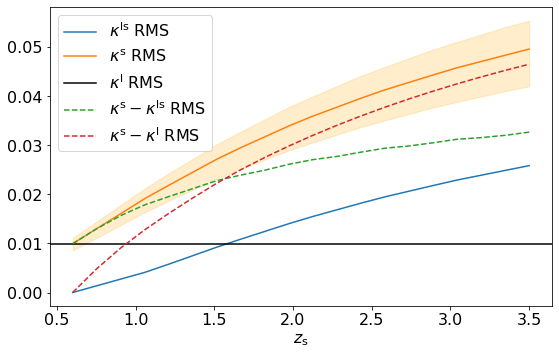

In [3]:
# Plotting the comparison between RMS of different \kappa
plt.figure(figsize=(9,5.5))
z_plot = np.linspace(0.6, 3.5, 20)
plt.plot(z_plot, kappa_ls_interp(z_plot), label=r'$\kappa^{\rm ls}$ RMS')
plt.plot(z_plot, kappa_s_interp(z_plot), label=r'$\kappa^{\rm s}$ RMS')
#  plt.fill_between(z_plot, kappa_s_kmax5(z_plot), kappa_s_kmax20(z_plot), alpha=0.2, label=r'$\kappa^{\rm s} $ RMS band' )
plt.fill_between(z_plot, kappa_s_kmax5(z_plot), kappa_s_kmax20(z_plot), color='orange', alpha=0.2 )
plt.axhline(kappa_s_interp(0.6), color = 'black', label=r'$\kappa^{\rm l}$ RMS')
kappa_ls_s_plot = [delta_kappa_ext_ls_s(zi, zi) for zi in z_plot]
plt.plot(z_plot, kappa_ls_s_plot, linestyle='dashed', label=r'$\kappa^{\rm s} - \kappa^{\rm ls}$ RMS')
kappa_l_s_plot = [delta_kappa_ext(0.6, zi) for zi in z_plot]
plt.plot(z_plot, kappa_l_s_plot, linestyle='dashed', label=r'$\kappa^{\rm s} - \kappa^{\rm l}$ RMS')
plt.xlabel(r'$z_{\rm s}$')
plt.legend()
# plt.savefig('../images/kappa_ls_s_l.pdf')
plt.show()

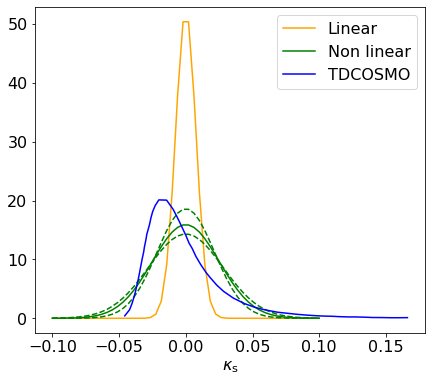

Galaxy name & $\sigma_{\rm lin}$  & $\sigma_{\rm halofit}$  & $ \kappa_{\rm ext}^{\rm TDCOSMO} $ &  quantiles ratio (lin)  &  quantiles ratio (halofit) \\


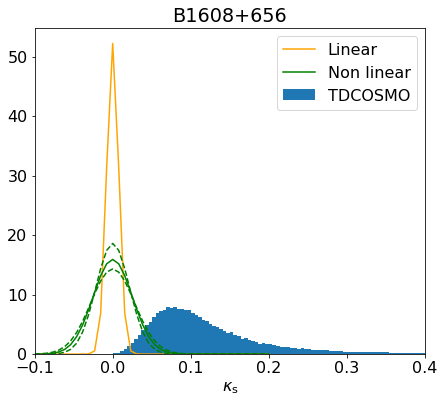

<Figure size 432x288 with 0 Axes>

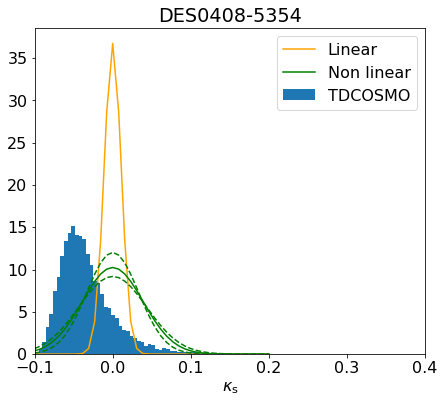

<Figure size 432x288 with 0 Axes>

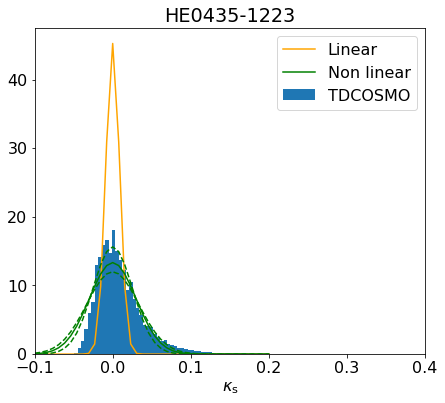

<Figure size 432x288 with 0 Axes>

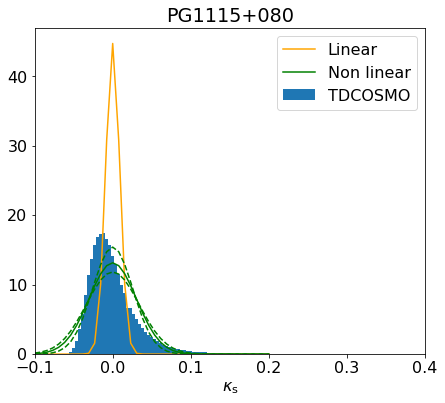

<Figure size 432x288 with 0 Axes>

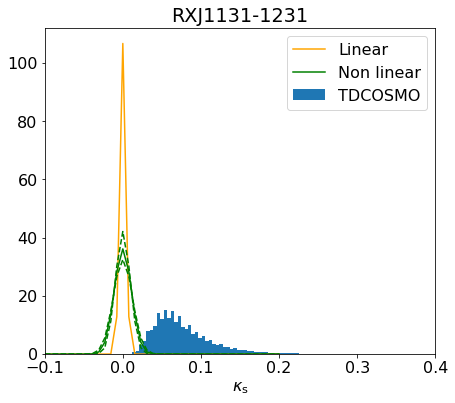

<Figure size 432x288 with 0 Axes>

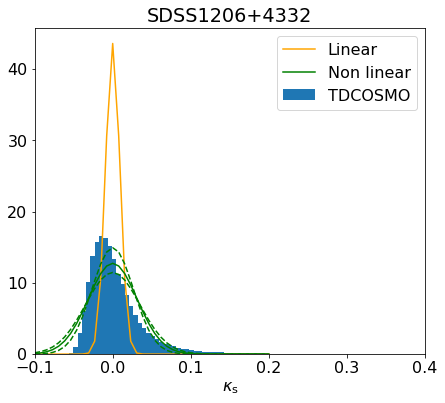

<Figure size 432x288 with 0 Axes>

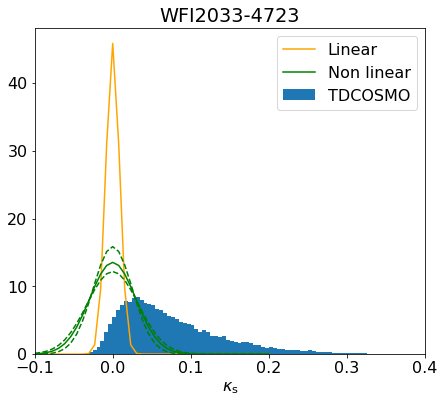

<Figure size 432x288 with 0 Axes>

In [7]:
# Comparison with TDCOSMO systems
sigma = kappa_s_interp(1.394)
sigma5 = kappa_s_kmax5(1.394) # kmax = 5
sigma20 = kappa_s_kmax20(1.394) # kmax = 20
array = np.genfromtxt('data_ext_kappa/Default_Dataset.csv', delimiter=',')

# Linear result computed from other program
kappa_ext_linear = [0.007640986788508158, 0.010864940841415214, 0.008813835032837353, 0.008917342435143357, 0.003738124426029788, 0.009150157926993419, 0.008701305964513042]

plot_array = np.linspace(-0.10, 0.10, 50)

plt.figure(figsize=(7,6))
plt.plot(plot_array, 1/np.sqrt(2*np.pi) /kappa_ext_linear[0] * np.exp(-plot_array**2/2/kappa_ext_linear[0]**2), color='orange', label='Linear')
plt.plot(plot_array, 1/np.sqrt(2*np.pi) /sigma * np.exp(-plot_array**2/2/sigma**2), color='green', label='Non linear')
plt.plot(plot_array, 1/np.sqrt(2*np.pi) /sigma5 * np.exp(-plot_array**2/2/sigma5**2), color='green', linestyle='dashed')
plt.plot(plot_array, 1/np.sqrt(2*np.pi) /sigma20 * np.exp(-plot_array**2/2/sigma20**2), color='green', linestyle='dashed')
plt.plot(array[:,0], array[:,1], color='blue', label='TDCOSMO')
plt.legend()
plt.xlabel(r'$\kappa_{\rm s} $')
# plt.savefig('plots/kappa_ext_B1608+656_all_los_'+str(kmax)+'.pdf')
plt.show()

name_galaxies = ['B1608+656', 'DES0408-5354', 'HE0435-1223', 'PG1115+080', 'RXJ1131-1231', 'SDSS1206+4332', 'WFI2033-4723' ]

kappa_SDSS = np.loadtxt('data_ext_kappa/kappahist_J1206_measured_5innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_zoverr_45_gal_45_zoverr_24_med_increments4_4_4_4.cat', delimiter=',', skiprows=1)
data_kappa_ext = [
        np.loadtxt('data_ext_kappa/B1608_kext.txt', delimiter='\t', skiprows=1),
        np.loadtxt('data_ext_kappa/DES0408_kext_sampled.txt', delimiter=',', skiprows=1),
        np.loadtxt('data_ext_kappa/kappa_powerlaw_he.dat', delimiter=',', skiprows=1),
        np.loadtxt('data_ext_kappa/kappa_powerlaw_pg.dat', delimiter=',', skiprows=1),
        np.loadtxt('data_ext_kappa/kappa_powerlaw_rxj.dat', delimiter=',', skiprows=1),
        np.linspace(start=-0.1, stop=1, num=len(kappa_SDSS)),
        np.loadtxt('data_ext_kappa/wfi2033_kext_bic_pdf.dat', delimiter=',', skiprows=1)[:,0]
        ]
data_weights = [
        None, None, None, None, None,
        np.array(kappa_SDSS),
        np.array(np.loadtxt('data_ext_kappa/wfi2033_kext_bic_pdf.dat', delimiter=',', skiprows=1)[:,1]),
        ]

z_source = [1.394, 2.375, 1.693, 1.722, 0.654, 1.789, 1.662]
z_lens = [0.6304, 0.597, 0.4546, 0.311, 0.295, 0.745, 0.6575]

from statsmodels.stats.weightstats import DescrStatsW
print('Galaxy name'+' & '+r'$\sigma_{\rm lin}$ '+' & '+r'$\sigma_{\rm halofit}$ '+' & '+r'$ \kappa_{\rm ext}^{\rm TDCOSMO} $'+' & '+' quantiles ratio (lin) '+' & '+' quantiles ratio (halofit) '+'\\\\')
for i in range(len(name_galaxies)):
    wq = DescrStatsW(data = np.array(data_kappa_ext[i]), weights = data_weights[i])
    q_16, q_50, q_86 = wq.quantile(probs=np.array([0.16, 0.5, 0.86] ), return_pandas = False)
    sigma_kappa_tdcosmo = wq.std
for i in range(len(name_galaxies)):
    plt.figure(figsize=(7,6))
    plt.hist(data_kappa_ext[i], weights= data_weights[i], bins=200, density=True, stacked=True, label='TDCOSMO')
    kappa_array = np.linspace(-0.1,0.2, 40)
    plt.plot(kappa_array, 1/np.sqrt(2*np.pi) /kappa_ext_linear[i] * np.exp(-kappa_array**2/2/kappa_ext_linear[i]**2), color='orange', label='Linear')
    plt.plot(kappa_array, 1/np.sqrt(2*np.pi) /kappa_s_interp(z_source[i]) * np.exp(-kappa_array**2/2/kappa_s_interp(z_source[i])**2), color='green', label='Non linear')
    plt.plot(kappa_array, 1/np.sqrt(2*np.pi) /kappa_s_kmax5(z_source[i]) * np.exp(-kappa_array**2/2/kappa_s_kmax5(z_source[i])**2), color='green', linestyle='dashed')
    plt.plot(kappa_array, 1/np.sqrt(2*np.pi) /kappa_s_kmax20(z_source[i]) * np.exp(-kappa_array**2/2/kappa_s_kmax20(z_source[i])**2), color='green', linestyle='dashed')
    plt.title(name_galaxies[i])
    plt.xlabel(r'$\kappa_{\rm s} $')
    plt.xlim(-0.1,0.4)
    plt.legend()
    #  plt.savefig('plots/kappa_ext_comparison_camb_nonlinear_'+name_galaxies[i]+'_kmax_'+str(kmax)+'.pdf')
    plt.show()
    plt.clf()

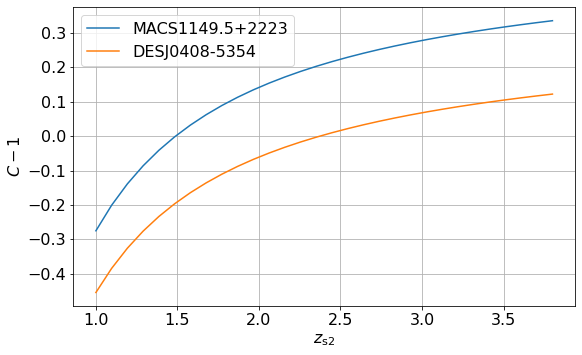

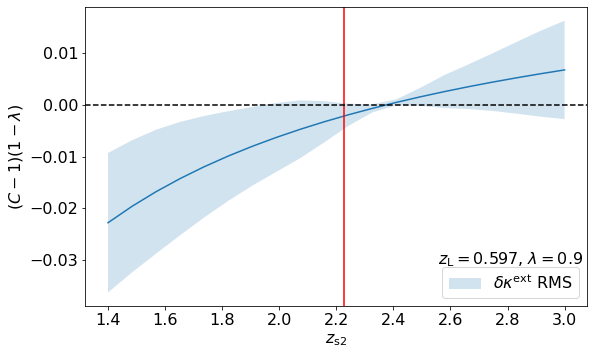

/tmp/ipykernel_13701/1257531004.py:300: RuntimeWarning: invalid value encountered in sqrt
  kappa_tot = np.sqrt(kappa_s_lin_interp(z_s1)**2 + kappa_s_lin_interp(z_s2)**2 - 2* kappa_s_lin_interp2d.ev(z_s1,z_s2)**2)


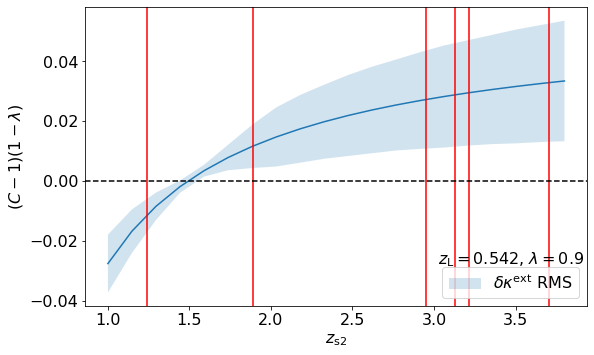

In [5]:
# Cosmological C factor
def C_factor(z_lens, z_1, z_2):
    d_1 = results.angular_diameter_distance(z_1)
    d_l2 = results.angular_diameter_distance2(z_lens, z_2)
    d_l1 = results.angular_diameter_distance2(z_lens, z_1)
    d_2 = results.angular_diameter_distance(z_2)
    return  d_1 * d_l2 / d_2 / d_l1

# Cluster MACS1149.5+2223 and DESJ0408-5354 plots
z_lens_DES = 0.597
z_lens = 0.542
z_s1 = 1.489 # mimick Grillo, Refsdal redshift
z_s1_DES = 2.375 # mimick DES system
# Cosmological factor
def C_factor(z_lens, z_1, z_2):
    d_1 = results.angular_diameter_distance(z_1)
    d_l2 = results.angular_diameter_distance2(z_lens, z_2)
    d_l1 = results.angular_diameter_distance2(z_lens, z_1)
    d_2 = results.angular_diameter_distance(z_2)
    return  d_1 * d_l2 / d_2 / d_l1

# C factor plot
plt.figure(figsize=(9,5.5))
z_plot = np.linspace(1, 3.8, 30)
C_plot = [C_factor(z_lens, z_s1, zi) - 1 for zi in z_plot]
C_plot_DES = [C_factor(z_lens_DES, z_s1_DES, zi)-1 for zi in z_plot]
plt.plot(z_plot, C_plot, label='MACS1149.5+2223')
plt.plot(z_plot, C_plot_DES, label='DESJ0408-5354')
plt.legend()
plt.grid()
plt.xlabel(r'$z_{\rm s2}$')
plt.ylabel(r'$ C-1 $')
#  plt.savefig('../images/C_plot.pdf')
plt.show()

plt.figure(figsize=(9,5.5))
z_lens = 0.597 # mimick 1910.06306
z_s1 = 2.375
z_array = np.linspace(1.4, 3.0, 20)
lambda_msd = 0.9
cosmo_msd = np.array([(C_factor(z_lens, z_s1, z_i) -1)*(1-lambda_msd) for z_i in z_array])
delta_kappa_array = np.array([delta_delta_kappa_ext_ls_s(z_s1, z_i) for z_i in z_array])
plt.plot(z_array, cosmo_msd)
plt.fill_between(z_array, cosmo_msd - delta_kappa_array, cosmo_msd+delta_kappa_array, alpha=0.2, label=r'$\delta\kappa^{\rm ext} $ RMS' )
plt.xlabel(r'$ z_{\rm s2} $')
plt.ylabel(r'$ (C-1)(1-\lambda) $')
plt.figtext(.67, .23, r'$ z_{\rm L} = %1.3f $, $\lambda = %1.1f$' % (z_lens, lambda_msd) )
plt.axvline(2.228, color='red')
plt.axhline(y=0, linestyle='--', color='black')
plt.legend(loc='lower right')
#  plt.savefig('../images/kappa_ext_correction_camb_nonlinear_kmax_'+str(kmax)+'.pdf')
plt.show()

z_lens = 0.542
z_array = np.linspace(1, 3.8, 20)
lambda_msd = 0.9
z_s1_clust = 1.489
cosmo_msd = np.array([(C_factor(z_lens, z_s1_clust, z_i) -1)*(1-lambda_msd) for z_i in z_array])
delta_kappa_array = np.array([delta_delta_kappa_ext_ls_s(z_i, z_s1_clust) for z_i in z_array])
delta_kappa_linear = np.array([delta_kappa_lin(z_i, z_s1_clust) for z_i in z_array])
cluster_sources = [1.240, 1.892, 2.949, 3.130, 3.216, 3.703 ]

# Plotting
plt.figure(figsize=(9,5.5))
plt.plot(z_array, cosmo_msd)
plt.fill_between(z_array, cosmo_msd - delta_kappa_array, cosmo_msd+delta_kappa_array, alpha=0.2, label=r'$\delta\kappa^{\rm ext} $ RMS' )
plt.xlabel(r'$ z_{\rm s2} $')
plt.ylabel(r'$ (C-1)(1-\lambda) $')
plt.figtext(.67, .23, r'$ z_{\rm L} = %1.3f $, $\lambda = %1.1f$' % (z_lens, lambda_msd) )
for zi in cluster_sources:
    plt.axvline(zi, color='red')
plt.axhline(y=0, linestyle='--', color='black')
plt.legend(loc='lower right')
#  plt.savefig('../images/kappa_ext_cluster_camb_nonlinear_kmax_'+str(kmax)+'.pdf')
plt.show()